<a href="https://colab.research.google.com/github/lasiadhi/Prediction-of-hypoxemia-trend/blob/master/XGB_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#################################################
###### @author: Lasith Adhikari (python 3)  #####
############ Created on Dec 1, 2019 ############
# Code description: 
# Train XGB-ML models to predict hypoxemia transition
# Added baseline PF (PF1 as a feature)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import os

random.seed(9001)
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
#from sklearn.ensemble import RandomForestClassifier
#from pygam import LogisticGAM
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
import time 
from sklearn.metrics import precision_recall_curve
#from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200


In [0]:
# XGB model: 
def fitXGBClassifier(X_train, X_test, y_train, y_test):
    
    print ('Parameter tunning and feature selection for XGBClassifier: ')
    
    kbest = SelectKBest(f_classif)  # ANOVA F-value between label/feature for classification tasks (F-test captures only linear dependency)
    
    clf = xgb.XGBClassifier(random_state=0, missing=-999, reg_lambda=0)   
    
    pipeline = Pipeline([('kbest', kbest), ('xgb', clf)])
    
    # first run:
    # https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

    n_est               = [1000] # default=100
    max_depth           = [3,5]  # default=3 
    kbest_vals          = [50, 60, 'all']
    learning_rate       = [0.0001, 0.0005]  # default=0.1
    min_child_weight    = [1,2,3,4] #default=1 (int) -- Minimum sum of instance weight(hessian) needed in a child)
    subsample           = [0.8,1] #default= 1 , (float) – Subsample ratio of the training instance.
    colsample_bytree    = [0.8,1] #default=1, (float) – Subsample ratio of columns when constructing each tree.
    reg_alpha           = [0.5,1] # default=0 (float (xgb's alpha)) – L1 regularization term on weights
    scale_pos_weight    = [1,2,3] #default=1 (float) – Balancing of positive and negative weights.
    
    '''
    # second run:
    n_est               = [500] # default=100
    max_depth           = [3,5]  # default=3 
    kbest_vals          = [50,60,70]
    learning_rate       = [0.0005,0.01]  # default=0.1
    min_child_weight    = [3] #default=1 (int) -- Minimum sum of instance weight(hessian) needed in a child)
    subsample           = [1] #default= 1 , (float) – Subsample ratio of the training instance.
    colsample_bytree    = [0.7,0.8,0.9] #default=1, (float) – Subsample ratio of columns when constructing each tree.
    '''
    
    param_grid = { 
    'kbest__k' : kbest_vals,
    'xgb__n_estimators': n_est, 
    'xgb__max_depth': max_depth,
    'xgb__learning_rate': learning_rate,
    'xgb__min_child_weight': min_child_weight,
    'xgb__subsample': subsample,
    'xgb__colsample_bytree': colsample_bytree,
    'xgb__reg_alpha': reg_alpha,
    'xgb__scale_pos_weight': scale_pos_weight
    }
    
    
    CV_rfc = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv= 5,verbose=2,n_jobs=-1)
    CV_rfc.fit(X_train, y_train)
    print (CV_rfc.best_params_)   # print the best parameters
    
    # perform preditction using the best RF model
    predicted_y = CV_rfc.predict(X_test)
    probs       = CV_rfc.predict_proba(X_test)

    # generate some evaluation metrics
    print ('Accuracy of the RF model with selected features: ', metrics.accuracy_score(y_test, predicted_y))
    print ('ROC-AUC of the RF model with selected features: ',  metrics.roc_auc_score(y_test, probs[:,1]))   
    
    finalFeatureIndices = CV_rfc.best_estimator_.named_steps['kbest'].get_support(indices=True)
    X_important_train = X_train.iloc[:, finalFeatureIndices]
    X_important_test = X_test.iloc[:, finalFeatureIndices]
    
    
    print ("Selected features for the model: ", list(X_important_train.columns))
    return probs[:,1],X_important_train,X_important_test, CV_rfc

In [0]:
def plot_metrics(y_test,pred_probs_RF):
    
    # generate a df with 'tn','fp','fn','tp' for all thresholds
    df_values = pd.DataFrame(columns=['tn','fp','fn','tp'])
    thresholds = np.arange(min(pred_probs_RF),max(pred_probs_RF),0.005)
    for cut in thresholds:
        y_score_ = (pred_probs_RF>cut)*1
        row = pd.Series(list(metrics.confusion_matrix(y_test, y_score_).ravel()),index=['tn','fp','fn','tp'], name=cut)
        df_values = df_values.append(row)
    #compute specificty
    spec = df_values['tn']/(df_values['tn']+df_values['fp']+1e-100) # added 1e-100 to avoid div by zero by any case
    #compute sensitivity (recall)
    sen = df_values['tp']/(df_values['tp']+df_values['fn']+1e-100)
    #compute precesion
    pres = df_values['tp']/(df_values['tp']+df_values['fp']+1e-100)
    
    plt.gcf().set_size_inches(15, 8)
    plt.plot(thresholds, pres, 'b', label='Precision (PPV)')
    plt.plot(thresholds, sen, 'g', label = 'Recall (Sensitivity)')
    plt.plot(thresholds, spec, 'r', label = 'Specificity')
    plt.xlabel('Threshold', fontsize=15)
    plt.legend(loc='lower center', fontsize=15)
    plt.ylim([0,1])
    #plt.axvline(x=optimal_threshold, color='black',linestyle='dashed')
    plt.show()

In [0]:
# Define data file path to be read
FILENAME_X_test = '../Data/data_with_baseline_PF/X_test.csv' 
FILENAME_X_train = '../Data/data_with_baseline_PF/X_train.csv' 
FILENAME_y_test = '../Data/data_with_baseline_PF/y_test.csv' 
FILENAME_y_train = '../Data/data_with_baseline_PF/y_train.csv' 

X_train = pd.read_csv(FILENAME_X_train, index_col=0)
X_test = pd.read_csv(FILENAME_X_test, index_col=0)
y_train = pd.read_csv(FILENAME_y_train, index_col=0)
y_test = pd.read_csv(FILENAME_y_test, index_col=0)

In [0]:
# Imputations for XGB (XGB can handle missing values):
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

In [0]:
X_train.shape

(6767, 80)

In [0]:
X_test.shape

(2901, 80)

In [0]:
# code categrorical columns:
X_train['gender'] = X_train['gender'].astype('category').cat.codes
X_test['gender'] = X_test['gender'].astype('category').cat.codes

X_train['ethnicity'] = X_train['ethnicity'].astype('category').cat.codes
X_test['ethnicity'] = X_test['ethnicity'].astype('category').cat.codes

X_train['unittype'] = X_train['unittype'].astype('category').cat.codes
X_test['unittype'] = X_test['unittype'].astype('category').cat.codes

X_train['unitstaytype'] = X_train['unitstaytype'].astype('category').cat.codes
X_test['unitstaytype'] = X_test['unitstaytype'].astype('category').cat.codes

X_train['BMI_category'] = X_train['BMI_category'].astype('category').cat.codes
X_test['BMI_category'] = X_test['BMI_category'].astype('category').cat.codes

X_train['is_low_urine'] = X_train['is_low_urine'].astype('category').cat.codes
X_test['is_low_urine'] = X_test['is_low_urine'].astype('category').cat.codes

X_train['vasopressor'] = X_train['vasopressor'].astype('category').cat.codes
X_test['vasopressor'] = X_test['vasopressor'].astype('category').cat.codes

X_train['min_t_gcs'] = X_train['min_t_gcs'].astype('category').cat.codes
X_test['min_t_gcs'] = X_test['min_t_gcs'].astype('category').cat.codes

X_train['max_t_gcs'] = X_train['max_t_gcs'].astype('category').cat.codes
X_test['max_t_gcs'] = X_test['max_t_gcs'].astype('category').cat.codes

In [0]:
y_train.is_worse = y_train.is_worse.astype('category').cat.codes
y_test.is_worse = y_test.is_worse.astype('category').cat.codes

In [0]:
# test for any null values:
print('Null in X_train: ', X_train.isnull().sum(axis=0).sum())
print('Null in X_test: ', X_test.isnull().sum(axis=0).sum())

# check dump model accuracy (if we predict every test case as 1)
dump_accuracy = (y_test.sum()/len(y_test))*100
print ('Dump model accuracy (if we predict all test cases as 1):' + str(dump_accuracy))

Null in X_train:  0
Null in X_test:  0
Dump model accuracy (if we predict all test cases as 1):is_worse    22.268183
dtype: float64


In [0]:
## XGB Classifier model with CV
pred_probs_XGB, iXtrain, iXtest, CV_rfc = fitXGBClassifier(X_train, X_test, y_train.is_worse, y_test.is_worse)

Parameter tunning and feature selection for XGBClassifier: 
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed: 48.9min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed: 75.6min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed: 106.1min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed: 139.2min
[Parallel(n_jobs=-1)]: Done 3249 tasks      | elapsed: 182.0min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 238.8min
[Parallel(n_jobs=-1)]: Done 4869 tasks      | elapsed: 306.2min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 410.9min finished


{'kbest__k': 50, 'xgb__colsample_bytree': 1, 'xgb__learning_rate': 0.0005, 'xgb__max_depth': 3, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 1000, 'xgb__reg_alpha': 0.5, 'xgb__scale_pos_weight': 3, 'xgb__subsample': 0.8}
Accuracy of the RF model with selected features:  0.6677007928300586
ROC-AUC of the RF model with selected features:  0.8007856637812085
Selected features for the model:  ['gender', 'unitstaytype', 'min_t_respiratoryrate', 'min_t_spo2', 'min_t_nibp_systolic', 'min_t_nibp_diastolic', 'min_t_temperature', 'max_t_respiratoryrate', 'max_t_spo2', 'max_t_nibp_systolic', 'max_t_nibp_diastolic', 'max_t_nibp_mean', 'max_t_temperature', 'avg_t_respiratoryrate', 'avg_t_spo2', 'avg_t_nibp_systolic', 'avg_t_nibp_diastolic', 'avg_t_nibp_mean', 'avg_t_temperature', 'min_t_BUN', 'min_t_calcium', 'min_t_creatinine', 'min_t_bicarbonate', 'min_t_sodium', 'min_t_wbc', 'min_t_RBC', 'min_t_anion gap', 'min_t_chloride', 'max_t_BUN', 'max_t_calcium', 'max_t_creatinine', 'max_t_bicarbonate

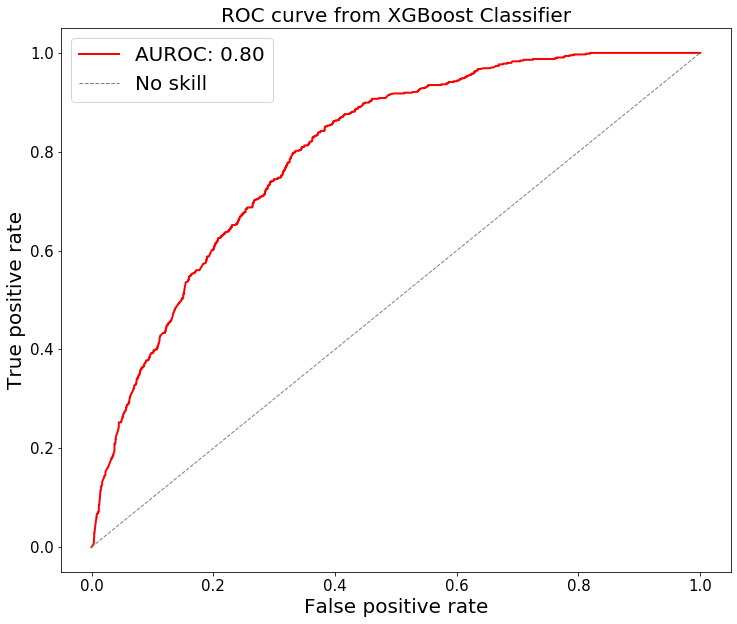

In [0]:
# XGB - draw ROC and compute the AUC 
fpr, tpr, thresholds = roc_curve(y_test, pred_probs_XGB)
roc_auc = auc(fpr, tpr)

# plotting ROCs
plt.gcf().set_size_inches(12, 10)
plt.plot(fpr, tpr, lw=2, color='red', label='AUROC: %0.2f'% roc_auc)
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--', label='No skill')
plt.ylabel('True positive rate', fontsize=20)
plt.xlabel('False positive rate', fontsize=20)
plt.title('ROC curve from XGBoost Classifier', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.show()

Feature ranking:
1. feature: baseline_PF (0.266967)
2. feature: vasopressor (0.030144)
3. feature: avg_t_anion gap (0.027261)
4. feature: min_t_anion gap (0.026896)
5. feature: avg_t_creatinine (0.026354)
6. feature: max_t_nibp_mean (0.026248)
7. feature: avg_t_spo2 (0.025837)
8. feature: min_t_calcium (0.025825)
9. feature: avg_t_nibp_diastolic (0.025548)
10. feature: avg_t_respiratoryrate (0.025361)
11. feature: avg_t_nibp_systolic (0.025250)
12. feature: avg_t_BUN (0.024774)
13. feature: max_t_anion gap (0.024543)
14. feature: min_t_chloride (0.024221)
15. feature: min_t_respiratoryrate (0.023903)
16. feature: min_t_wbc (0.023792)
17. feature: max_t_chloride (0.023492)
18. feature: min_t_BUN (0.023395)
19. feature: max_t_nibp_diastolic (0.023308)
20. feature: max_t_temperature (0.023171)
21. feature: min_t_RBC (0.022991)
22. feature: max_t_nibp_systolic (0.022745)
23. feature: max_t_wbc (0.022645)
24. feature: avg_t_calcium (0.022485)
25. feature: avg_t_RBC (0.022137)
26. feature: m

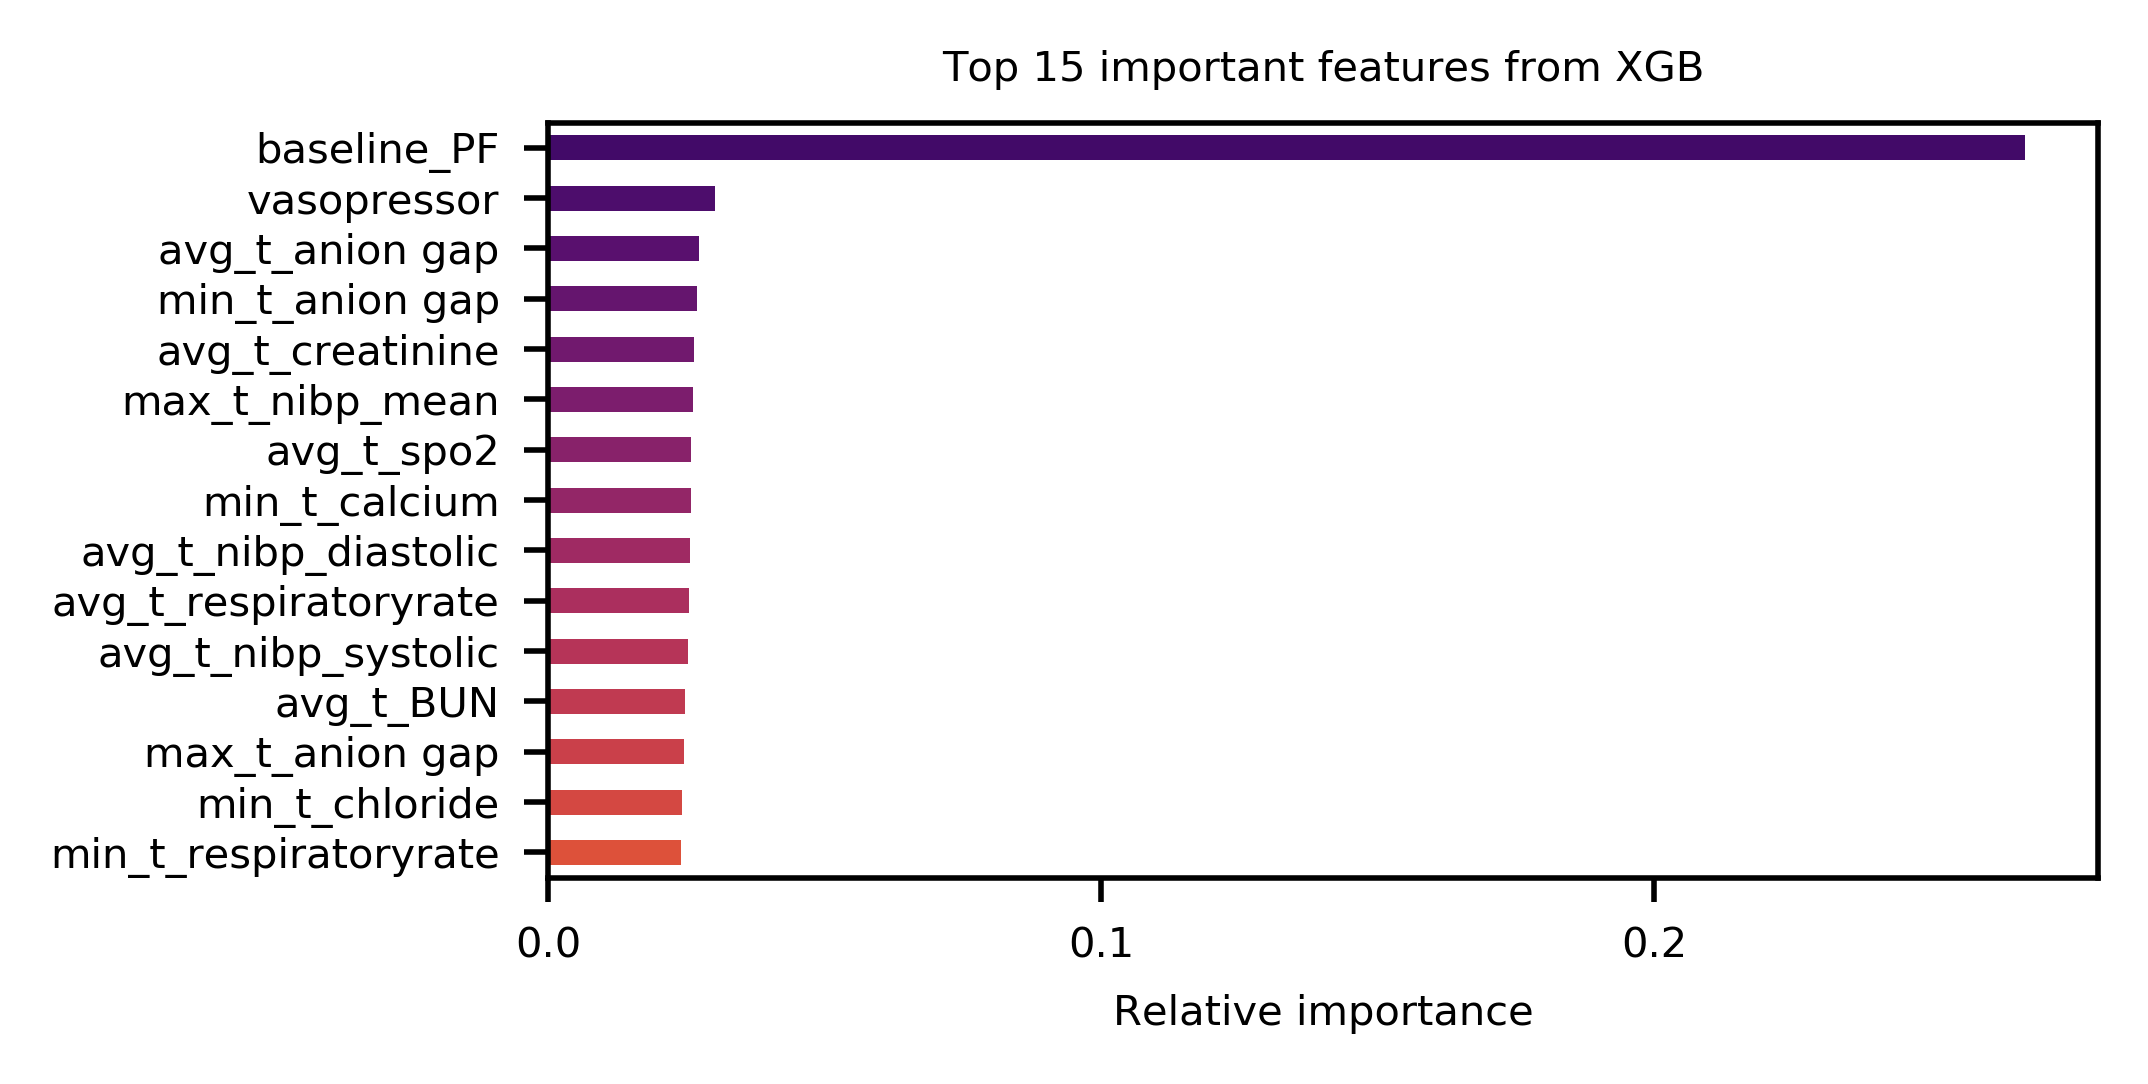

In [0]:
####### feature importances from XGB ##############
forest = CV_rfc.best_estimator_.steps[1][1]
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(len(importances)):
    print("%d. feature: %s (%f)" % (f + 1, iXtrain.columns[indices[f]], importances[indices[f]]))

# importance plot:
#plt.gcf().set_size_inches(15, 6)
plt.figure(figsize=(4, 2), dpi=500)
feat_importances = pd.Series(importances[indices], index=iXtrain.columns[indices])
feat_importances.nlargest(15)[::-1].plot(kind='barh',fontsize=6,color=cm.inferno_r(np.linspace(.4,.8, 15)))
plt.title('Top 15 important features from XGB', fontsize=6)
plt.xlabel('Relative importance', fontsize=6)
plt.show()

In [0]:
feat_importances.nlargest(15)[:0:-1]

min_t_respiratoryrate    0.023903
min_t_chloride           0.024221
max_t_anion gap          0.024543
avg_t_BUN                0.024774
avg_t_nibp_systolic      0.025250
avg_t_respiratoryrate    0.025361
avg_t_nibp_diastolic     0.025548
min_t_calcium            0.025825
avg_t_spo2               0.025837
max_t_nibp_mean          0.026248
avg_t_creatinine         0.026354
min_t_anion gap          0.026896
avg_t_anion gap          0.027261
vasopressor              0.030144
dtype: float32

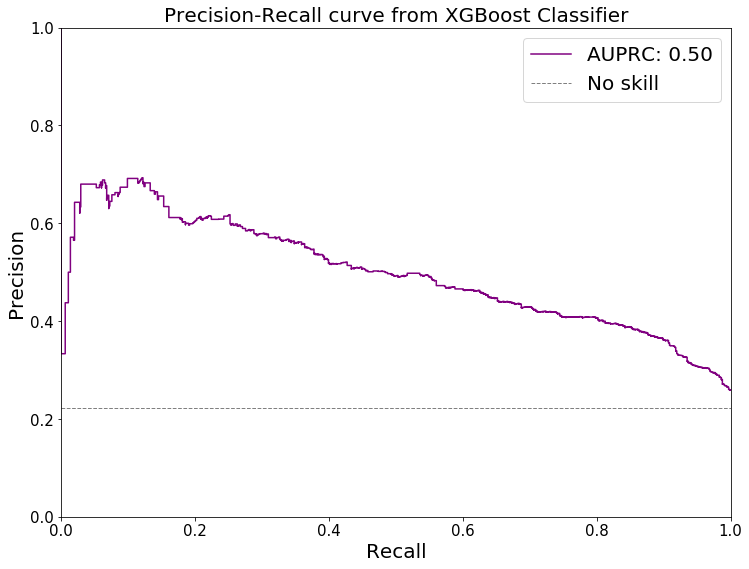

In [0]:
########## Plotting Precision-recall curve ############
precision, recall, _ = precision_recall_curve(np.array(y_test), pred_probs_XGB)
#average_precision = average_precision_score(y_test, pred_probs_XGB)
pr_auc = auc(recall, precision)
plt.gcf().set_size_inches(12, 9)
plt.step(recall, precision, color='purple', alpha=1, where='post', label='AUPRC: %0.2f'% pr_auc)
plt.axhline(y = sum(y_test.is_worse)/len(y_test.is_worse), linewidth=1, color='gray', linestyle='--', label='No skill')
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.title('Precision-Recall curve from XGBoost Classifier',fontsize=20)
plt.legend(loc='upper right', fontsize=20)

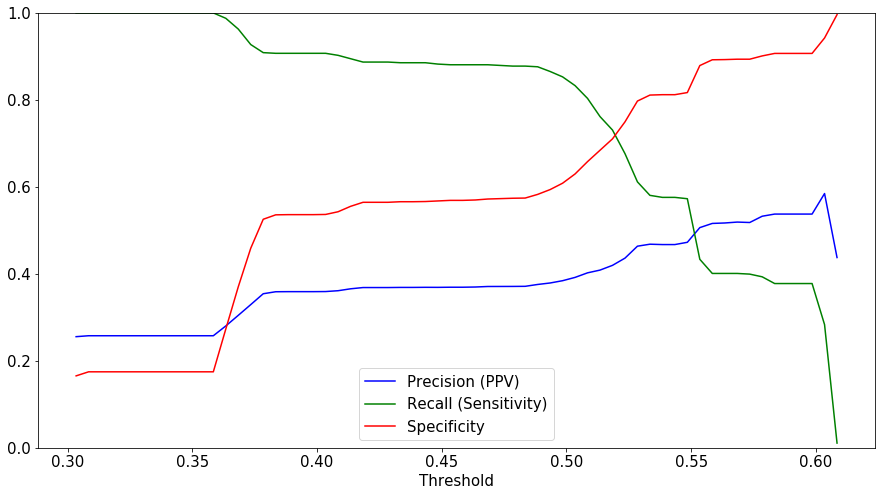

In [0]:
plot_metrics(y_test,pred_probs_XGB)

In [0]:
# Export data
################# Write results to the disk ##################
df_pred_scores = pd.DataFrame(pred_probs_XGB)
df_pred_scores.columns = ['XGBoost']
df_y_test = pd.DataFrame(y_test)
df_y_test.columns = ['true_outcome']
df_y_test = df_y_test.reset_index(level=0)
df_results = pd.concat([df_y_test, df_pred_scores],axis=1)
#df_results.to_csv("Testset_prediction_results_XGB.csv",index=False)

# Second run after further tunning parameters

In [0]:
## XGB Classifier model with CV
pred_probs_XGB, iXtrain, iXtest, CV_rfc = fitXGBClassifier(X_train, X_test, y_train.is_worse, y_test.is_worse)

In [0]:
# XGB - draw ROC and compute the AUC 
fpr, tpr, thresholds = roc_curve(y_test, pred_probs_XGB)
roc_auc = auc(fpr, tpr)

# plotting ROCs
plt.gcf().set_size_inches(12, 10)
plt.plot(fpr, tpr, lw=2, color='red', label='AUROC: %0.2f'% roc_auc)
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--', label='No skill')
plt.ylabel('True positive rate', fontsize=20)
plt.xlabel('False positive rate', fontsize=20)
plt.title('ROC curve from XGBoost Classifier', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.show()

In [0]:
####### feature importances from XGB ##############
forest = CV_rfc.best_estimator_.steps[1][1]
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(len(importances)):
    print("%d. feature: %s (%f)" % (f + 1, iXtrain.columns[indices[f]], importances[indices[f]]))

# importance plot:
plt.gcf().set_size_inches(15, 6)
feat_importances = pd.Series(importances[indices], index=iXtrain.columns[indices])
feat_importances.nlargest(10)[::-1].plot(kind='barh',fontsize=15,color=cm.inferno_r(np.linspace(.4,.8, 10)))
plt.title('Top 10 important features', fontsize=15)
plt.show()

In [0]:
########## Plotting Precision-recall curve ############
precision, recall, _ = precision_recall_curve(np.array(y_test), pred_probs_XGB)
pr_auc = auc(recall, precision)
plt.gcf().set_size_inches(12, 9)
plt.step(recall, precision, color='purple', alpha=1, where='post', label='AUPRC: %0.2f'% pr_auc)
plt.axhline(y = sum(y_test.is_worse)/len(y_test.is_worse), linewidth=1, color='gray', linestyle='--', label='No skill')
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.title('Precision-Recall curve from XGBoost Classifier',fontsize=20)
plt.legend(loc='upper right', fontsize=20)